In [ ]:
%pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
# Import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from scipy.special import softmax, expit

import json, codecs
import traceback, logging
import argparse
import datetime
import pandas as pd
import numpy as np
import os
import holidays
import pandas
import torch

from datetime import date, timedelta, time
from multiprocessing import Pool
from functools import partial
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 16 12:28:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  path_prefix = '/content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/'
  print("Running in Google Colab.")
else:
  path_prefix = './'
  print("Not running in Google Colab.")

print(f"Using path prefix: {path_prefix}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Google Colab.
Using path prefix: /content/drive/MyDrive/Great Learning/DBA/Walsh-MS-QM640CapstoneProject/


In [ ]:
gplay_ip_file = f"{path_prefix}extracts/gplay_reviews_2020-2025_processed.xlsx"
apstr_ip_file = f"{path_prefix}extracts/appstr_reviews_2020-2025_processed.xlsx"
adhoc_sched_lookup = f"{path_prefix}Lookup/adhoc_schedule.json"
modeleng = f"{path_prefix}sentiment_eng"
modelmulti = f"{path_prefix}sentiment_multi"

In [ ]:
#2021
####----- Considering 8:00 AM  - 8:00 PM as Business Working Hours (Sunday-Thursday)----#### 12hrs
####----- Considering 10:00 AM - 6:00 PM as Business Working Hours (Saturday)----#### 8hrs
#2022
####----- Considering 8:00 AM  - 8:00 PM as Business Working Hours (Monday-Thursday)----#### 12hrs
####----- Considering 8:00 AM - 12:00 PM & 2:00 PM - 6:00 PM as Business Working Hours (Friday)----#### 8hrs
####----- Considering 10:00 AM - 6:00 PM as Business Working Hours (Saturday)----#### 8hrs

def get_years():
    years= []

    start_year = 2020
    curr_year = datetime.datetime.now().year

    year = start_year
    for i in range(curr_year-start_year+1):
      years.append(year)
      year = year+1
    return years

def get_adhoc_holidays():
    try:
        df = pd.DataFrame(config['holidays'])
        df['date'] = df['date'].astype('datetime64[ns]').dt.date
        df.drop_duplicates('date',keep='last',inplace=True)
        return df
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def get_adhoc_workhours():
    try:
        df = pd.DataFrame(config['work_hours'])
        df['date'] = df['date'].astype('datetime64[ns]').dt.date
        df.drop_duplicates('date',keep='last',inplace=True)
        return df
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def get_holiday_dates():
    try:
        holiday_list = []
        years = get_years()
        for holiday in holidays.UnitedArabEmirates(years=years).items():
            holiday_list.append(holiday)

        holidays_df = pd.DataFrame(holiday_list, columns=["date", "holiday"])
        holidays_df['weekday'] = holidays_df['date'].astype('datetime64[ns]').dt.day_name()

        holidays_df = holidays_df[~holidays_df['date'].isin(df_adhoc_workdays['date'])]

        holidays_df = holidays_df.merge(df_adhoc_holidays.drop_duplicates(), on=['date'],how='outer')
        holidays_df['holiday'] = holidays_df.holiday_x.combine_first(holidays_df.holiday_y)
        holidays_df['weekday'] = holidays_df.weekday_x.combine_first(holidays_df.weekday_y)
        holidays_df.drop(columns=['holiday_x','weekday_x','holiday_y','weekday_y'],inplace=True)

        holidays_df.reset_index(inplace=True, drop=True)
        holidays_df = holidays_df.sort_values(by=['date'],ignore_index=True)
        return holidays_df
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def is_holiday(dt):
    try:
        if (dt.date() in holidays_df['date'].tolist()): # check to identify if its a Govt Holiday
            return True
        elif (dt.year<=2021) and (dt.weekday() in [4]): # Weekend Check - Considering Only Friday as Holiday before 2022
            return True
        elif (dt.year>=2022) and (dt.weekday() in [6]): #Weekend Check - Considering Only Sunday as Holiday from 2022
            return True
        return False
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def get_working_hours(dt):
    try:
        if dt.date() in df_adhoc_workdays['date'].tolist():
            start_hour = df_adhoc_workdays[df_adhoc_workdays['date'] == dt.date()]['start_hour'].item()
            end_hour = df_adhoc_workdays[df_adhoc_workdays['date'] == dt.date()]['end_hour'].item()
            return (time(start_hour,0), time(end_hour,0))
        elif dt.year <=2021:
            working_hours = {
                6: (time(8,0), time(20,0)), # Sunday
                0: (time(8,0), time(20,0)), # Monday
                1: (time(8,0), time(20,0)), # Tuesday
                2: (time(8,0), time(20,0)), # Wednesday
                3: (time(8,0), time(20,0)), # Thursday
                5: (time(10,0), time(18,0)), # Saturday
            }
        elif dt.year >= 2022:
            working_hours = {
                0: (time(8,0), time(20,0)), # Monday
                1: (time(8,0), time(20,0)), # Tuesday
                2: (time(8,0), time(20,0)), # Wednesday
                3: (time(8,0), time(20,0)), # Thursday
                4: (time(8,0), time(18,0)), # Friday
                5: (time(10,0), time(18,0)), # Saturday
            }
        return working_hours[dt.weekday()]
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def get_eta_secs(dt):
    try:
        if dt.year >= 2023 and dt.month >= 2: # After 1stFeb'23, ETA changed from 24 hrs (86400secs) to 12 hrs (43200secs)
            eta_secs = 43200
        else:
            eta_secs = 86400
        return eta_secs
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e


def get_total_work_hours(dt):
    try:
        start_hour, end_hour = get_working_hours(dt)
        total_work_hours = end_hour.hour - start_hour.hour
        if (dt.year >= 2022) and (dt.weekday() in [4]):
            total_work_hours = total_work_hours - 2 # 2 hours Break 12:00PM-14:00PM
        return start_hour, end_hour, total_work_hours
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e


def get_at_date(dt):
    try:
        if (((dt.year <= 2021) and (dt.weekday() not in [4])) or ((dt.year >= 2022) and (dt.weekday() not in [6]))) and (not is_holiday(dt)):
            dt_start_hour, dt_end_hour = get_working_hours(dt)
        else:
            dt_start_hour, dt_end_hour = time(0,0), time(0,0)

        if ((dt.hour >= dt_end_hour.hour) or (dt.hour < dt_start_hour.hour)):
            if (dt.hour >= dt_end_hour.hour):
                dt += timedelta(days=1)
                while is_holiday(dt):
                    dt += timedelta(days=1)
            start_hour, end_hour = get_working_hours(dt)
            dt = datetime.datetime.combine(dt, start_hour)

        if (dt.year >= 2022) and (dt.weekday() in [4]):
            if ((dt.hour > 12) and (dt.hour < 14)):
                dt = datetime.datetime.combine(dt, time(14,0))
        return dt
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e


def get_eta_date(dt):
    try:
        eta_secs = get_eta_secs(dt) # Get ETA in secs
        at_dt = get_at_date(dt)   # Calculated review date considering working hours and holidays
        current_date = at_dt
        respCntr = 0
        while eta_secs > 0:
            if is_holiday(current_date):
                current_date += timedelta(days=1)
            else:
                start_hour, end_hour, wrkg_hours = get_total_work_hours(current_date)
                if respCntr > 0:
                    current_date = datetime.datetime(current_date.year, current_date.month, current_date.day, start_hour.hour)
                secs_diff = ((end_hour.hour)*60*60) - (int(current_date.hour)*60*60 + int(current_date.minute)*60 + int(current_date.second))
                if (current_date.year >= 2022) and (current_date.weekday() in [4]): # To compensate 2 breakhours on Friday
                    secs_diff = secs_diff - (2*60*60)
                if secs_diff >= eta_secs:
                    eta_hours = eta_secs/3600
                    current_date = current_date + timedelta(hours=eta_hours)
                    if (current_date.year >= 2022) and (current_date.weekday() in [4]):
                        if (current_date.hour > 12):
                            current_date = current_date + timedelta(hours=2)
                    return at_dt, current_date
                eta_secs -= secs_diff
                current_date += timedelta(days=1)
                respCntr = respCntr + 1
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def set_tom(x):  # For any given date returns next day's date 8:00 AM or 10:00 AM
    try:
        x = x + pd.DateOffset(1)
        if ((x.year <= 2021) and (x.weekday() not in [4])) or ((x.year >= 2022) and (x.weekday() not in [6])):
            x_start_hour, x_end_hour = get_working_hours(x)
        else:
            x_start_hour, x_end_hour = time(0,0), time(0,0)
        x = datetime.datetime.combine(x, x_start_hour)
        return x
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e


def cal_diff(x,y): # Calculate actual hrs taken to reply a review (TurnAround Hours) (calc review date-x ; replied date-y)
    try:
        if ((isinstance(x,pandas._libs.tslibs.nattype.NaTType)) or (isinstance(y,pandas._libs.tslibs.nattype.NaTType))):
            return np.nan
        else:
            respCntr = 0
            x_start_hour, x_end_hour = get_working_hours(x)
            diff = (y-x).total_seconds() / 3600    # calcualte difference between given dates and Convert to hrs
            if diff < 0:                           # if replied date < calc review date (if replied within weekends/holidays) return 0hrs
                return 0
            elif ((x.day == y.day) & (y.hour >= x_start_hour.hour) & (y.hour < x_end_hour.hour)): # if replied on same date as calc review date and within working hrs of that day, return diff as-is
                return diff
            else:                                  # if replied date > calc review date (shift calc review date to next day and run this method in recursive until x date reaches y date)
                x_start_hour, x_end_hour = get_working_hours(x)
                endTime = datetime.datetime.combine(x, x_end_hour) # set to end of business hrs
                todDiff = (endTime-x).total_seconds() / 3600       # to calculate hours past till end of business hrs on calc review date
                if (endTime.year >= 2022) and (endTime.weekday() in [4]):
                    todDiff = todDiff - 2
                x = set_tom(x) #
                while is_holiday(x):
                    x = set_tom(x)
                respCntr = respCntr + cal_diff(x,y) + todDiff     # recursive loop to calcualte hrs taken (handles scenario when replied out of business hrs, i.e. if < 8 or > 20, when calculation it implicitly caps to 20:00 prev day or next day respectively )
                return respCntr
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def get_sla_status(x):
    try:
        cutoff = pd.to_timedelta('0d 0h 0m')
        na_dates = pd.to_timedelta('-1000d 0h 0m')

        if x == na_dates:
            sla_status = 'Not Responded'
        elif x > cutoff:
            sla_status = 'SLA Met'
        else:
            sla_status = 'SLA Missed'

        return sla_status
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def find_arabic(string):
    try:
        # Convert input to string to handle potential non-string types (like floats)
        string = str(string)
        arabic = 0
        for ch in string:
            if ('\u0600' <= ch <= '\u06FF' or
                '\u0750' <= ch <= '\u077F' or
                '\u08A0' <= ch <= '\u08FF' or
                '\uFB50' <= ch <= '\uFDFF' or
                '\uFE70' <= ch <= '\uFEFF' or
                '\U00010E60' <= ch <= '\U00010E7F' or
                '\U0001EE00' <= ch <= '\U0001EEFF'):
                arabic = arabic + 1
                break
        if arabic > 0:
            return 'ar'
        else:
            return 'en'
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def get_responded_by(txt):
    if not pd.isna(txt):
        txt = txt.strip()
        txt = txt.strip('.')
        if '\n' in txt:
            txt = txt.split('\n')[-1]
            if len(txt) > 3 and '.' in txt[-2:]:
                txt = txt[-3:]
        elif '.' in txt[-2:]:
            txt = txt[-3:]
        else:
            txt = 'N/A'
    return txt

def save_dataframe(df, op_file_path, op_file_type):
    try:
        if  op_file_type == "csv":
            df.to_csv(op_file_path + '.' + op_file_type, header=1, encoding="utf-8-sig",index=False)
        elif op_file_type == "xlsx":
            writer = pd.ExcelWriter(op_file_path + '.' + op_file_type, engine='xlsxwriter')
            df.to_excel(writer,index=False)
            writer.close()
        else:
            print("\nInvalid File Type - Please pass either csv or xlsx")
            logging.info("\nInvalid File Type - Please pass either csv or xlsx")
            raise
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

## Read Files for Processing

In [ ]:
df_gplay = pd.read_excel(gplay_ip_file)
df_gplay.head()

,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,at_year,at_month,country
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,2025,7,NaN
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,2025,6,NaN
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,ayasafputri love,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,id,2025,6,NaN
3,1780c47d-38ad-4563-92c3-c381b717171f,Ismail Momin,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,en,2025,6,NaN
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Abdullah Khalil fareh Almahri,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,en,2025,6,NaN


In [ ]:
print(df_gplay.shape)
df_gplay.columns

(58126, 13)


Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country'],
      dtype='object')

In [ ]:
df_gplay['app_name'].value_counts()

,count
app_name,
ADCB,9900
FAB Mobile,9900
Emirates NBD,9900
ADIB Mobile Banking App,8632
Mashreq UAE,7807
DIB MOBILE,5576
RAKBANK App,2714
HSBC UAE,1515
EI Bank,967


In [ ]:
import pandas as pd
df_appstr = pd.read_excel(apstr_ip_file)
df_appstr.head()

,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,at_year,at_month,country
0,12833901269,TA78_,For some reason I can't transfer money. It doe...,2,2025-06-30 09:32:15,We hear your concern and are committed to impr...,2025-07-17 13:14:16,Apple App Store,ADCB,en,2025,6,ae
1,12826382370,Royal1439,The app was working good but from yesterday it...,3,2025-06-28 11:19:06,Thank you for your review! We're happy the app...,2025-07-17 13:20:08,Apple App Store,ADCB,en,2025,6,ae
2,12823377454,Ashkaf Khan,This is very convenient mean time monthly amou...,5,2025-06-27 17:16:31,Thank you for your review! We're happy the app...,2025-07-17 13:19:32,Apple App Store,ADCB,en,2025,6,ae
3,12823033272,Maysahan,This application is convenient to use once you...,2,2025-06-27 15:30:02,NaN,NaT,Apple App Store,ADCB,en,2025,6,ae
4,12822944588,DayanHanan,"Cannot open my app for a 10 hours. I updated, ...",1,2025-06-27 14:59:51,We hear your concern and are committed to impr...,2025-07-17 13:13:26,Apple App Store,ADCB,en,2025,6,ae


In [ ]:
print(df_appstr.shape)
df_appstr.columns

(10753, 13)


Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country'],
      dtype='object')

In [ ]:
df_appstr['app_name'].value_counts()

,count
app_name,
ENBD,1949
ADIB,1633
ADCB,1574
FAB,1559
Mashreq,917
DIB,884
EI Bank,656
HSBC Bank,605
RAKBANK,496


In [ ]:
df = pd.concat([df_gplay, df_appstr], ignore_index=True)
print(df.shape)
print(df.columns)
df.head()

(68879, 13)
Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country'],
      dtype='object')


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,at_year,at_month,country
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,2025,7,NaN
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,2025,6,NaN
2,6262b57b-7c21-4f6b-9a6a-b4fa8d60b395,ayasafputri love,good,5,2025-06-30 21:42:32,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:03,Google Play Store,ADCB,id,2025,6,NaN
3,1780c47d-38ad-4563-92c3-c381b717171f,Ismail Momin,good thank you,5,2025-06-30 19:14:18,"Hello, thank you for the encouraging star rati...",2025-07-01 12:49:00,Google Play Store,ADCB,en,2025,6,NaN
4,5083ac69-2298-45ee-9b96-1912e10dfed6,Abdullah Khalil fareh Almahri,Dear adcb bank i had a trouble on the Applicat...,5,2025-06-30 19:08:16,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:52,Google Play Store,ADCB,en,2025,6,NaN


In [ ]:
df['app_name'].value_counts()

,count
app_name,
ADCB,11474
Emirates NBD,9900
FAB Mobile,9900
ADIB Mobile Banking App,8632
Mashreq UAE,7807
DIB MOBILE,5576
RAKBANK App,2714
ENBD,1949
ADIB,1633


In [ ]:
# Clean and standardize app_name column
# Define a mapping for standard app names
app_name_map = {
    "FAB Mobile": "FAB",
    "ADIB Mobile Banking App": "ADIB",
    "Emirates NBD":"ENBD",
    "Mashreq UAE": "Mashreq",
    "DIB MOBILE": "DIB",
    "RAKBANK App": "RAKBANK",
    "HSBC UAE": "HSBC",
    "HSBC Bank": "HSBC",
    "Citibank UAE": "Citibank",
    "Citi Bank": "Citibank",
    "SC Mobile Banking (UAE)": "SC Bank",
}

# Apply the mapping to standardize app_name
df['app_name'] = df['app_name'].replace(app_name_map)
df['app_name'].value_counts()

,count
app_name,
ENBD,11849
ADCB,11474
FAB,11459
ADIB,10265
Mashreq,8724
DIB,6460
RAKBANK,3210
HSBC,2120
EI Bank,1623


In [ ]:
save_dataframe(df, f"{path_prefix}extracts/reviews_merged", "xlsx")

In [ ]:
df.columns

Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country'],
      dtype='object')

In [ ]:
df.dtypes

,0
reviewId,object
userName,object
reviewContent,object
rating,int64
reviewedAt,datetime64[ns]
replyContent,object
repliedAt,datetime64[ns]
store,object
app_name,object
language,object


In [ ]:
%%time
print("Processing Started", datetime.datetime.now())

with open(adhoc_sched_lookup, "r") as read_file:
    config = json.load(read_file)
df_adhoc_holidays = get_adhoc_holidays() # extracts list of adhoc holidays
df_adhoc_workdays = get_adhoc_workhours() # extracts list of adhoc workdays
holidays_df = get_holiday_dates() # extracts list of UAE holidays from python library

print("Getting ETA DATE", datetime.datetime.now())
df['at_calc'],  df['at_eta_date'] = zip(*df['reviewedAt'].apply(get_eta_date))

print("Getting REPLIED IN", datetime.datetime.now())
df['reply_in'] = df[['at_calc', 'repliedAt']].apply(lambda x:cal_diff(x.at_calc,x.repliedAt), axis=1)

print("Getting REPLIED DIFF W.R.T ETA", datetime.datetime.now())
df['reply_eta'] = (df['at_eta_date'] - df['repliedAt'])
df['reply_eta'] = df['reply_eta'].fillna(pd.to_timedelta('-1000d 0h 0m'))

print("Getting SLA STATUS", datetime.datetime.now())
df['sla_status'] = df['reply_eta'].apply(get_sla_status)

print("Language Detection", datetime.datetime.now())
df['lang_pred'] = df['reviewContent'].apply(find_arabic)

print("Extract Responded By", datetime.datetime.now())
df['responded_by'] = df['replyContent'].apply(get_responded_by)
df['responded_by'] = df['responded_by'].astype('str')

print("Processing Completed", datetime.datetime.now())
print(df.shape)

Processing Started 2025-08-16 14:04:22.559346
Getting ETA DATE 2025-08-16 14:04:22.574996
Getting REPLIED IN 2025-08-16 14:04:27.675961
Getting REPLIED DIFF W.R.T ETA 2025-08-16 14:04:40.379666
Getting SLA STATUS 2025-08-16 14:04:40.382120
Language Detection 2025-08-16 14:04:41.681236
Extract Responded By 2025-08-16 14:04:42.660391
Processing Completed 2025-08-16 14:04:42.705406
(68879, 20)
CPU times: user 19 s, sys: 55.2 ms, total: 19 s
Wall time: 20.1 s


In [ ]:
save_dataframe(df, f"{path_prefix}extracts/reviews_processed", "xlsx")

# Distribution of Ratings

/tmp/ipython-input-1362180219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rating', order=sorted(df['rating'].unique()), palette='viridis')


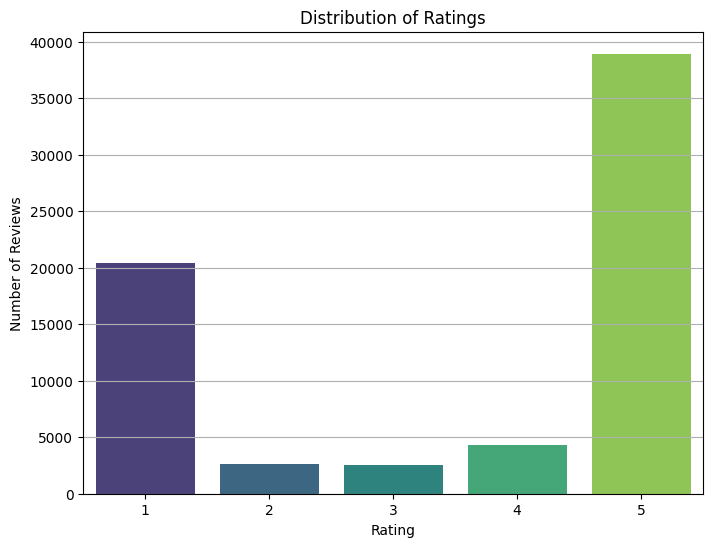

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='rating', order=sorted(df['rating'].unique()), palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.grid(axis='y')
plt.show()

### The plot shows that the majority of reviews have a rating of 5, followed by ratings of 1. Ratings of 2, 3, and 4 are less frequent. This indicates a bimodal distribution with a strong preference for extreme ratings.

## Scoring - GPU

In [ ]:
## Using GPU Load & Predict Sentiment Multi Model

#Load Models
model_multi = AutoModelForSequenceClassification.from_pretrained(modelmulti)
tokenizer_multi = AutoTokenizer.from_pretrained(modelmulti)

if torch.cuda.is_available():
  cuda = torch.device('cuda')
  model_multi.to('cuda')

def tensor_chunks(txt, tokenizer, encoded_input):# define target chunksize
    chunksize = 512

    # split into chunks of 510 tokens, we also convert to list (default is tuple which is immutable)
    input_id_chunks = list(encoded_input['input_ids'][0].split(chunksize - 2))
    mask_chunks = list(encoded_input['attention_mask'][0].split(chunksize - 2))

    # loop through each chunk
    for i in range(len(input_id_chunks)):
        # add CLS and SEP tokens to input IDs
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]), input_id_chunks[i], torch.tensor([102])
        ])
        # add attention tokens to attention mask
        mask_chunks[i] = torch.cat([
            torch.tensor([1]), mask_chunks[i], torch.tensor([1])
        ])
        # get required padding length
        pad_len = chunksize - input_id_chunks[i].shape[0]
        # check if tensor length satisfies required chunk size
        if pad_len > 0:
            # if padding length is more than 0, we must add padding
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i], torch.Tensor([0] * pad_len)
            ])
            mask_chunks[i] = torch.cat([
                mask_chunks[i], torch.Tensor([0] * pad_len)
            ])

    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)

    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()
    }
    return input_dict

def get_scores(x, tokenizer, model):
    try:
        # Convert input to string to handle potential non-string types (like floats or NaN)
        x = str(x)
        if torch.cuda.is_available(): #GPU
          device = torch.device('cuda')
          encoded_input = tokenizer(x, return_tensors='pt')
          if len(encoded_input['input_ids'][0]) > 512:
              encoded_input = tokenizer(x, return_tensors='pt',truncation='only_first', max_length = 512)
          encoded_input = encoded_input.to(device)
          output = model(**encoded_input)
          scores = output[0][0].cpu().detach().numpy()
          scores = softmax(scores)
          sigmoid_probs = expit(scores)
          return sigmoid_probs
        else: # CPU
          encoded_input = tokenizer(x, return_tensors='pt')
          if len(encoded_input['input_ids'][0]) > 512:
              encoded_input = tokenizer(x, return_tensors='pt',truncation='only_first', max_length = 512)
          output = model(**encoded_input)
          scores = output[0][0].cpu().detach().numpy()
          scores = softmax(scores)
          sigmoid_probs = expit(scores)
          return sigmoid_probs
    except Exception as e:
        logging.error(traceback.format_exc())
        # Return a default score or handle the error appropriately
        return np.array([0.0, 0.0, 0.0]) # Example: Return neutral scores

def scoring(df, tokenizer, model):
    try:
        df_ = df.copy()
        scores = df_.reviewContent.apply(get_scores, args=(tokenizer, model))
        Negative = scores.apply(lambda x:x[0])
        Neutral = scores.apply(lambda x:x[1])
        Positive = scores.apply(lambda x:x[2])
        df_['scores'] = scores
        df_['Negative'] = Negative
        df_['Neutral'] = Neutral
        df_['Positive'] = Positive
        return df_
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def parallelize_dataframe(df, func, tknzr, mdl, n_cores):
    try:
        df_split = np.array_split(df, n_cores)
        pool = Pool(n_cores)
        func_prt = partial(func, tokenizer=tknzr, model=mdl)
        df = pd.concat(pool.map(func_prt, df_split))
        pool.close()
        pool.join()
        return df
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

In [ ]:
%%time
df_scored = scoring(df, tokenizer_multi, model_multi)

CPU times: user 14min 27s, sys: 1.28 s, total: 14min 28s
Wall time: 14min 42s


In [ ]:
print(df_scored.shape)
df_scored.head(2)

(68879, 24)


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,at_eta_date,reply_in,reply_eta,sla_status,lang_pred,responded_by,scores,Negative,Neutral,Positive
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,...,2025-07-01 20:00:00,4.833056,0 days 07:10:01,SLA Met,en,A.E,"[0.71761656, 0.51372194, 0.50310713]",0.717617,0.513722,0.503107
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,...,2025-07-01 20:00:00,NaN,-1000 days +00:00:00,Not Responded,en,nan,"[0.5911989, 0.59655565, 0.5596994]",0.591199,0.596556,0.559699


In [ ]:
## Using GPU Load & Predict Sentiment English Model

#Load Models
model_eng = AutoModelForSequenceClassification.from_pretrained(modeleng)
tokenizer_eng = AutoTokenizer.from_pretrained(modeleng)

if torch.cuda.is_available():
  cuda = torch.device('cuda')
  model_eng.to('cuda')

def get_scores_(x, tokenizer, model):
    try:
      # Convert input to string to handle potential non-string types (like floats or NaN)
      x = str(x)
      if torch.cuda.is_available():
        device = torch.device('cuda')
        encoded_input = tokenizer(x, return_tensors='pt',truncation='only_first')
        encoded_input = encoded_input.to(device)
        output = model(**encoded_input)
        scores = output[0][0].cpu().detach().numpy()
        scores = softmax(scores)
        sigmoid_probs = expit(scores)
        return sigmoid_probs
      else:
        encoded_input = tokenizer(x, return_tensors='pt',truncation='only_first')
        output = model(**encoded_input)
        scores = output[0][0].cpu().detach().numpy()
        scores = softmax(scores)
        sigmoid_probs = expit(scores)
        return sigmoid_probs
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def scoring_(df, tokenizer, model):
    try:
        df_ = df.copy()
        scores_ = df_.reviewContent.apply(get_scores_, args=(tokenizer, model))
        Negative_ = scores_.apply(lambda x:x[0])
        Positive_ = scores_.apply(lambda x:x[1])
        df_['scores_'] = scores_
        df_['Negative_'] = Negative_
        df_['Positive_'] = Positive_
        return df_
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

def parallelize_dataframe(df, func, n_cores=2):
    try:
        df_split = np.array_split(df, n_cores)
        pool = Pool(n_cores)
        df = pd.concat(pool.map(func, df_split))
        pool.close()
        pool.join()
        return df
    except Exception as e:
        logging.error(traceback.format_exc())
        raise e

In [ ]:
%%time
df_scored_ = scoring_(df_scored, tokenizer_eng, model_eng)

CPU times: user 28min 35s, sys: 3.58 s, total: 28min 39s
Wall time: 29min 42s


In [ ]:
print(df_scored_.shape)
df_scored_['Sentiment'] = df_scored_[['Positive','Negative','Neutral']].idxmax(axis=1)
df_scored_['Sentiment_'] = df_scored_[['Positive_','Negative_']].idxmax(axis=1)

(68879, 27)


In [ ]:
df_scored_['Sentiment'].value_counts()

,count
Sentiment,
Positive,38461
Negative,24750
Neutral,5668


In [ ]:
df_scored_['Sentiment_'].value_counts()

,count
Sentiment_,
Positive_,45468
Negative_,23411


In [ ]:
save_dataframe(df_scored_, f"{path_prefix}scored/reviews_scored", "xlsx")

In [ ]:
df_scored_.columns

Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country', 'at_calc', 'at_eta_date', 'reply_in',
       'reply_eta', 'sla_status', 'lang_pred', 'responded_by', 'scores',
       'Negative', 'Neutral', 'Positive', 'scores_', 'Negative_', 'Positive_',
       'Sentiment', 'Sentiment_'],
      dtype='object')

## Define Function to Correct and Finalise sentiments

In [ ]:
def correct_sentiments(df, rating, content_):
    final = []
    for i in range(len(df)):
        if pd.isna(df.loc[i, content_]) or df.loc[i, content_] == 'nan':
            if df.loc[i,rating] >= 4:
                final.append('Positive')
            elif df.loc[i,rating] < 3:
                final.append('Negative')
            else:
                final.append('Neutral')
        elif df.loc[i, 'lang_pred'] != 'ar':
            if (df.loc[i, 'Sentiment'] == 'Neutral') and (df.loc[i, 'Sentiment_'] == 'Positive_'):
                if df.loc[i,rating] <= 3:
                    final.append('Neutral')
                elif df.loc[i,content_].isascii():
                    final.append('Positive')
                else:
                    final.append(df.loc[i, 'Sentiment'] )
            elif (df.loc[i, 'Sentiment'] == 'Negative') and (df.loc[i, 'Sentiment_'] == 'Positive_'):
                if df.loc[i,rating] <= 3:
                    final.append('Neutral')
                elif df.loc[i,content_].isascii():
                    final.append('Positive')
                else:
                    final.append(df.loc[i, 'Sentiment'] )
            elif (df.loc[i, 'Sentiment'] == 'Positive') and (df.loc[i, 'Sentiment_'] == 'Negative_'):
                if df.loc[i,rating] <= 3:
                    final.append('Neutral')
                else:
                    final.append('Positive')
            else:
                final.append(df.loc[i, 'Sentiment'])
        else:
            final.append(df.loc[i, 'Sentiment'])
    return final

In [ ]:
df_scored_['Prediction'] = correct_sentiments(df_scored_, 'rating', 'reviewContent')
print(df_scored_.shape)
df_scored_.head(2)

(68879, 30)


,reviewId,userName,reviewContent,rating,reviewedAt,replyContent,repliedAt,store,app_name,language,...,scores,Negative,Neutral,Positive,scores_,Negative_,Positive_,Sentiment,Sentiment_,Prediction
0,a2393404-7755-4564-add7-b3029159bb71,Farhat Taher,the application now for 4 days is not opening ...,1,2025-07-01 02:04:14,Sorry to hear you're having trouble with the a...,2025-07-01 12:49:59,Google Play Store,ADCB,en,...,"[0.71761656, 0.51372194, 0.50310713]",0.717617,0.513722,0.503107,"[0.73096216, 0.5001226]",0.730962,0.500123,Negative,Negative_,Negative
1,f521326b-0ffb-4620-8995-b04eeee01c8f,Lee Kasim,normal,3,2025-06-30 22:17:54,NaN,NaT,Google Play Store,ADCB,en,...,"[0.5911989, 0.59655565, 0.5596994]",0.591199,0.596556,0.559699,"[0.50245154, 0.7291262]",0.502452,0.729126,Neutral,Positive_,Neutral


## Distribution of Predicted Sentiment Status by Bank


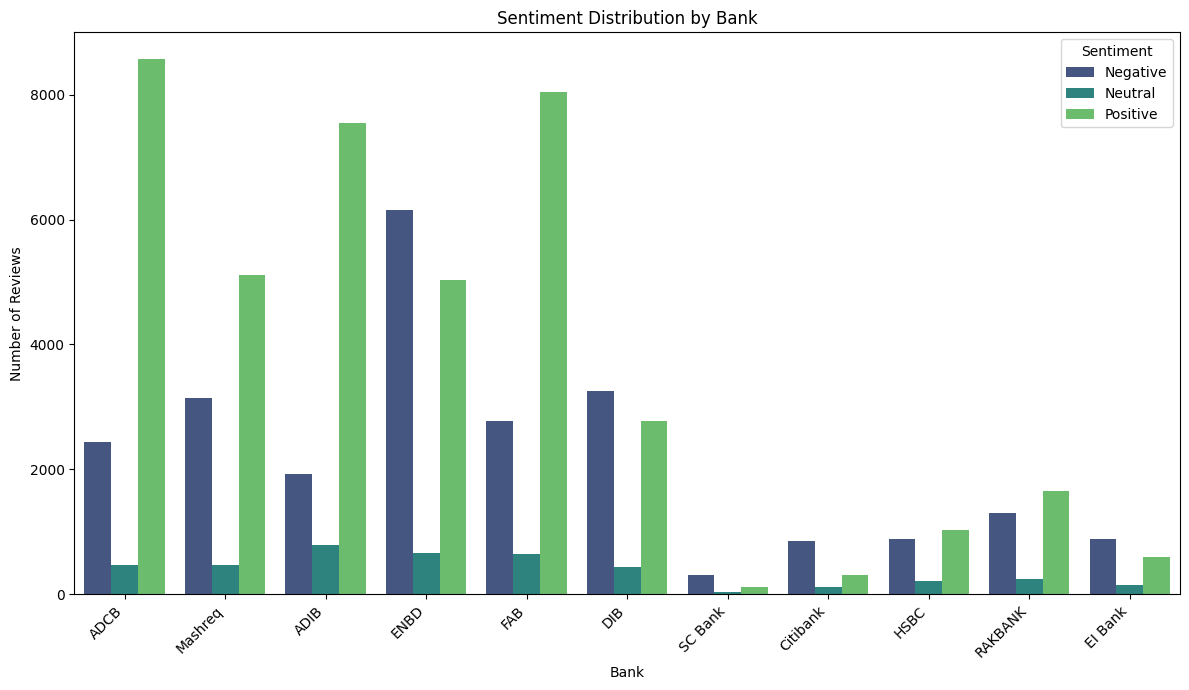

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.countplot(data=df_scored_, x='app_name', hue='Prediction', palette='viridis')
plt.title('Sentiment Distribution by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

###  This plot provides bank-by-bank comparison of sentiment distribution, highlighting which banks tend to receive more positive, negative, or neutral feedback based on the model's predictions. It shows that while a positive sentiment is dominant for few banks where the reviews volumne is also high, there's also variation in the sentiment mix for each individual bank.

In [ ]:
save_dataframe(df_scored_, f"{path_prefix}scored/reviews_sentiment_pred", "xlsx")

In [ ]:
df_scored_ = pd.read_excel(f"{path_prefix}scored/reviews_sentiment_pred.xlsx")

In [ ]:
df_scored_[['Sentiment','Sentiment_','Prediction']].groupby(['Sentiment','Sentiment_','Prediction']).size()

Sentiment  Sentiment_  Prediction
Negative   Negative_   Negative      20835
           Positive_   Negative       3064
                       Neutral         400
                       Positive        451
Neutral    Negative_   Neutral        1962
                       Positive          2
           Positive_   Neutral        1705
                       Positive       1999
Positive   Negative_   Neutral         129
                       Positive        483
           Positive_   Positive      37849
dtype: int64

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_scored_['sla_status'].value_counts()

,count
sla_status,
SLA Met,32302
Not Responded,24204
SLA Missed,12373


## Exploratory Analysis (RQ3)

In [ ]:
# Segment reviews into Replied and Not Replied
df_scored_['Response_Status'] = df_scored_['repliedAt'].apply(lambda x: 'Replied' if pd.notna(x) else 'Not Replied')

# Calculate the median TAT for replied reviews to segment into fast and slow
median_tat = df_scored_[df_scored_['Response_Status'] == 'Replied']['reply_in'].median()

# Segment replied reviews into Fast and Slow TAT
df_scored_['TAT_Group'] = df_scored_['reply_in'].apply(lambda x: 'Fast TAT' if x <= median_tat else 'Slow TAT' if pd.notna(x) else 'Not Applicable')

# Display the value counts for the new segmentation columns
print("Response Status Value Counts:")
display(df_scored_['Response_Status'].value_counts())

print("\nTAT Group Value Counts:")
display(df_scored_['TAT_Group'].value_counts())

print("\nCross-tabulation of Response Status and TAT Group:")
display(pd.crosstab(df_scored_['Response_Status'], df_scored_['TAT_Group']))

Response Status Value Counts:


,count
Response_Status,
Replied,44675
Not Replied,24204



TAT Group Value Counts:


,count
TAT_Group,
Not Applicable,24204
Fast TAT,22338
Slow TAT,22337



Cross-tabulation of Response Status and TAT Group:


TAT_Group,Fast TAT,Not Applicable,Slow TAT
Response_Status,,,
Not Replied,0,24204,0
Replied,22338,0,22337


## Distribution of Response Status by Bank

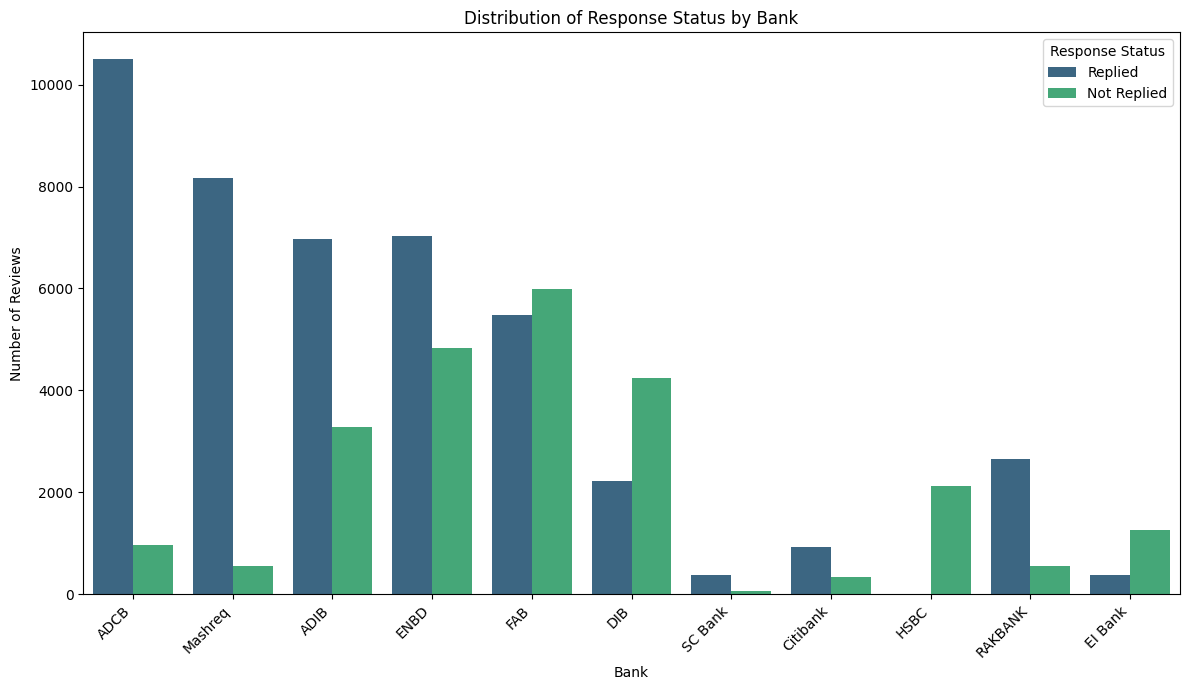

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of Response Status by bank
plt.figure(figsize=(12, 7))
sns.countplot(data=df_scored_, x='app_name', hue='Response_Status', palette='viridis')
plt.title('Distribution of Response Status by Bank')
plt.xlabel('Bank')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Response Status')
plt.tight_layout()
plt.show()

 ### This plot visualizes the response status (Replied vs. Not Replied) for reviews across different banks. It shows the count of reviews in each category for each bank, allowing for a comparison of response rates between banks. Some banks like ADCB, Mashreq, ADIB, ENBD, FAB have a higher proportion of replied reviews than others.

## Two-Proportion Z-Tests for Sentiment Differences between Fast and Slow TAT Groups

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Filter for replied reviews
replied_df = df_scored_[df_scored_['Response_Status'] == 'Replied'].copy()

# Segment into Fast and Slow TAT groups
fast_tat_df = replied_df[replied_df['TAT_Group'] == 'Fast TAT']
slow_tat_df = replied_df[replied_df['TAT_Group'] == 'Slow TAT']

# Define sentiment categories for testing (e.g., Positive, Negative)
sentiment_categories = ['Positive', 'Negative'] # We will use the 'Prediction' column for sentiment

print("Two-Proportion Z-Tests for Sentiment Differences between Fast and Slow TAT Groups:")

for sentiment in sentiment_categories:
    # Count the number of reviews in each TAT group with the current sentiment
    count_fast = fast_tat_df[fast_tat_df['Prediction'] == sentiment].shape[0]
    count_slow = slow_tat_df[slow_tat_df['Prediction'] == sentiment].shape[0]

    # Total number of reviews in each TAT group
    nobs_fast = fast_tat_df.shape[0]
    nobs_slow = slow_tat_df.shape[0]

    # Perform the two-proportion z-test
    stat, p_value = proportions_ztest([count_fast, count_slow], [nobs_fast, nobs_slow])

    print(f"\nSentiment: {sentiment}")
    print(f"  Null Hypothesis (H0): The proportion of {sentiment} sentiment is the same in Fast TAT and Slow TAT groups.")
    print(f"  Alternative Hypothesis (H1): The proportion of {sentiment} sentiment is different in Fast TAT and Slow TAT groups.")
    print(f"  Fast TAT ({nobs_fast} reviews): {count_fast} reviews with {sentiment} sentiment ({count_fast/nobs_fast:.2%})")
    print(f"  Slow TAT ({nobs_slow} reviews): {count_slow} reviews with {sentiment} sentiment ({count_slow/nobs_slow:.2%})")
    print(f"  Z-statistic: {stat:.4f}")
    print(f"  P-value: {p_value:.4f}")

    # Interpret the result
    alpha = 0.05
    if p_value < alpha:
        print(f"  Result: Reject null hypothesis - Significant difference in {sentiment} sentiment between Fast and Slow TAT groups.")
    else:
        print(f"  Result: Fail to reject null hypothesis - No significant difference in {sentiment} sentiment between Fast and Slow TAT groups.")

Two-Proportion Z-Tests for Sentiment Differences between Fast and Slow TAT Groups:

Sentiment: Positive
  Null Hypothesis (H0): The proportion of Positive sentiment is the same in Fast TAT and Slow TAT groups.
  Alternative Hypothesis (H1): The proportion of Positive sentiment is different in Fast TAT and Slow TAT groups.
  Fast TAT (22338 reviews): 13917 reviews with Positive sentiment (62.30%)
  Slow TAT (22337 reviews): 10538 reviews with Positive sentiment (47.18%)
  Z-statistic: 32.1126
  P-value: 0.0000
  Result: Reject null hypothesis - Significant difference in Positive sentiment between Fast and Slow TAT groups.

Sentiment: Negative
  Null Hypothesis (H0): The proportion of Negative sentiment is the same in Fast TAT and Slow TAT groups.
  Alternative Hypothesis (H1): The proportion of Negative sentiment is different in Fast TAT and Slow TAT groups.
  Fast TAT (22338 reviews): 7245 reviews with Negative sentiment (32.43%)
  Slow TAT (22337 reviews): 10389 reviews with Negative 

## Monthly Sentiment Trends Over Time

/tmp/ipython-input-1185174281.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment = df_scored_.groupby('Sentiment').resample('M', on='reviewedAt').size().unstack(fill_value=0)


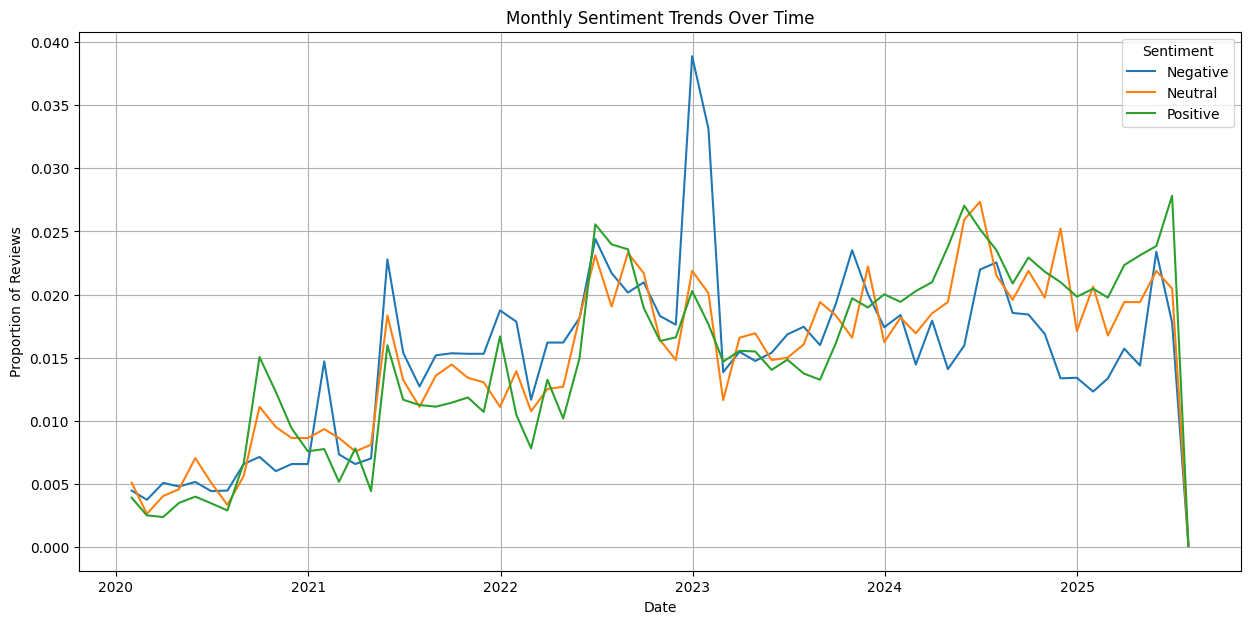

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'reviewedAt' is in datetime format
df_scored_['reviewedAt'] = pd.to_datetime(df_scored_['reviewedAt'])

# Resample data to monthly frequency and calculate the count of each sentiment
# Use the 'on' parameter to resample based on the 'reviewedAt' column without setting it as index
monthly_sentiment = df_scored_.groupby('Sentiment').resample('M', on='reviewedAt').size().unstack(fill_value=0)

# Calculate the proportion of each sentiment per month
monthly_sentiment_proportion = monthly_sentiment.divide(monthly_sentiment.sum(axis=1), axis=0)

# Reshape the data to long format for seaborn lineplot
monthly_sentiment_proportion_long = monthly_sentiment_proportion.stack().reset_index(name='proportion')
monthly_sentiment_proportion_long = monthly_sentiment_proportion_long.rename(columns={'level_0': 'Sentiment', 'reviewedAt': 'Date'})

# Plotting the temporal trends of sentiment
plt.figure(figsize=(15, 7))
sns.lineplot(data=monthly_sentiment_proportion_long, x='Date', y='proportion', hue='Sentiment')
plt.title('Monthly Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Proportion of Reviews')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

### The line plot illustrates the monthly trends of sentiment proportions over time. It shows how the proportion of Negative, Neutral, and Positive sentiments has changed from 2020 to 2025. There are visible fluctuations and potential seasonal patterns in the sentiment distribution.


In [ ]:
df_scored_.columns

Index(['reviewId', 'userName', 'reviewContent', 'rating', 'reviewedAt',
       'replyContent', 'repliedAt', 'store', 'app_name', 'language', 'at_year',
       'at_month', 'country', 'at_calc', 'at_eta_date', 'reply_in',
       'reply_eta', 'sla_status', 'lang_pred', 'responded_by', 'scores',
       'Negative', 'Neutral', 'Positive', 'scores_', 'Negative_', 'Positive_',
       'Sentiment', 'Sentiment_', 'Prediction', 'Response_Status',
       'TAT_Group'],
      dtype='object')

## Monthly Sentiment Trends Over Time Across Banks

/tmp/ipython-input-3058397899.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sentiment_by_bank = df_scored_.groupby(['app_name', 'Sentiment']).resample('M', on='reviewedAt').size().unstack(fill_value=0)


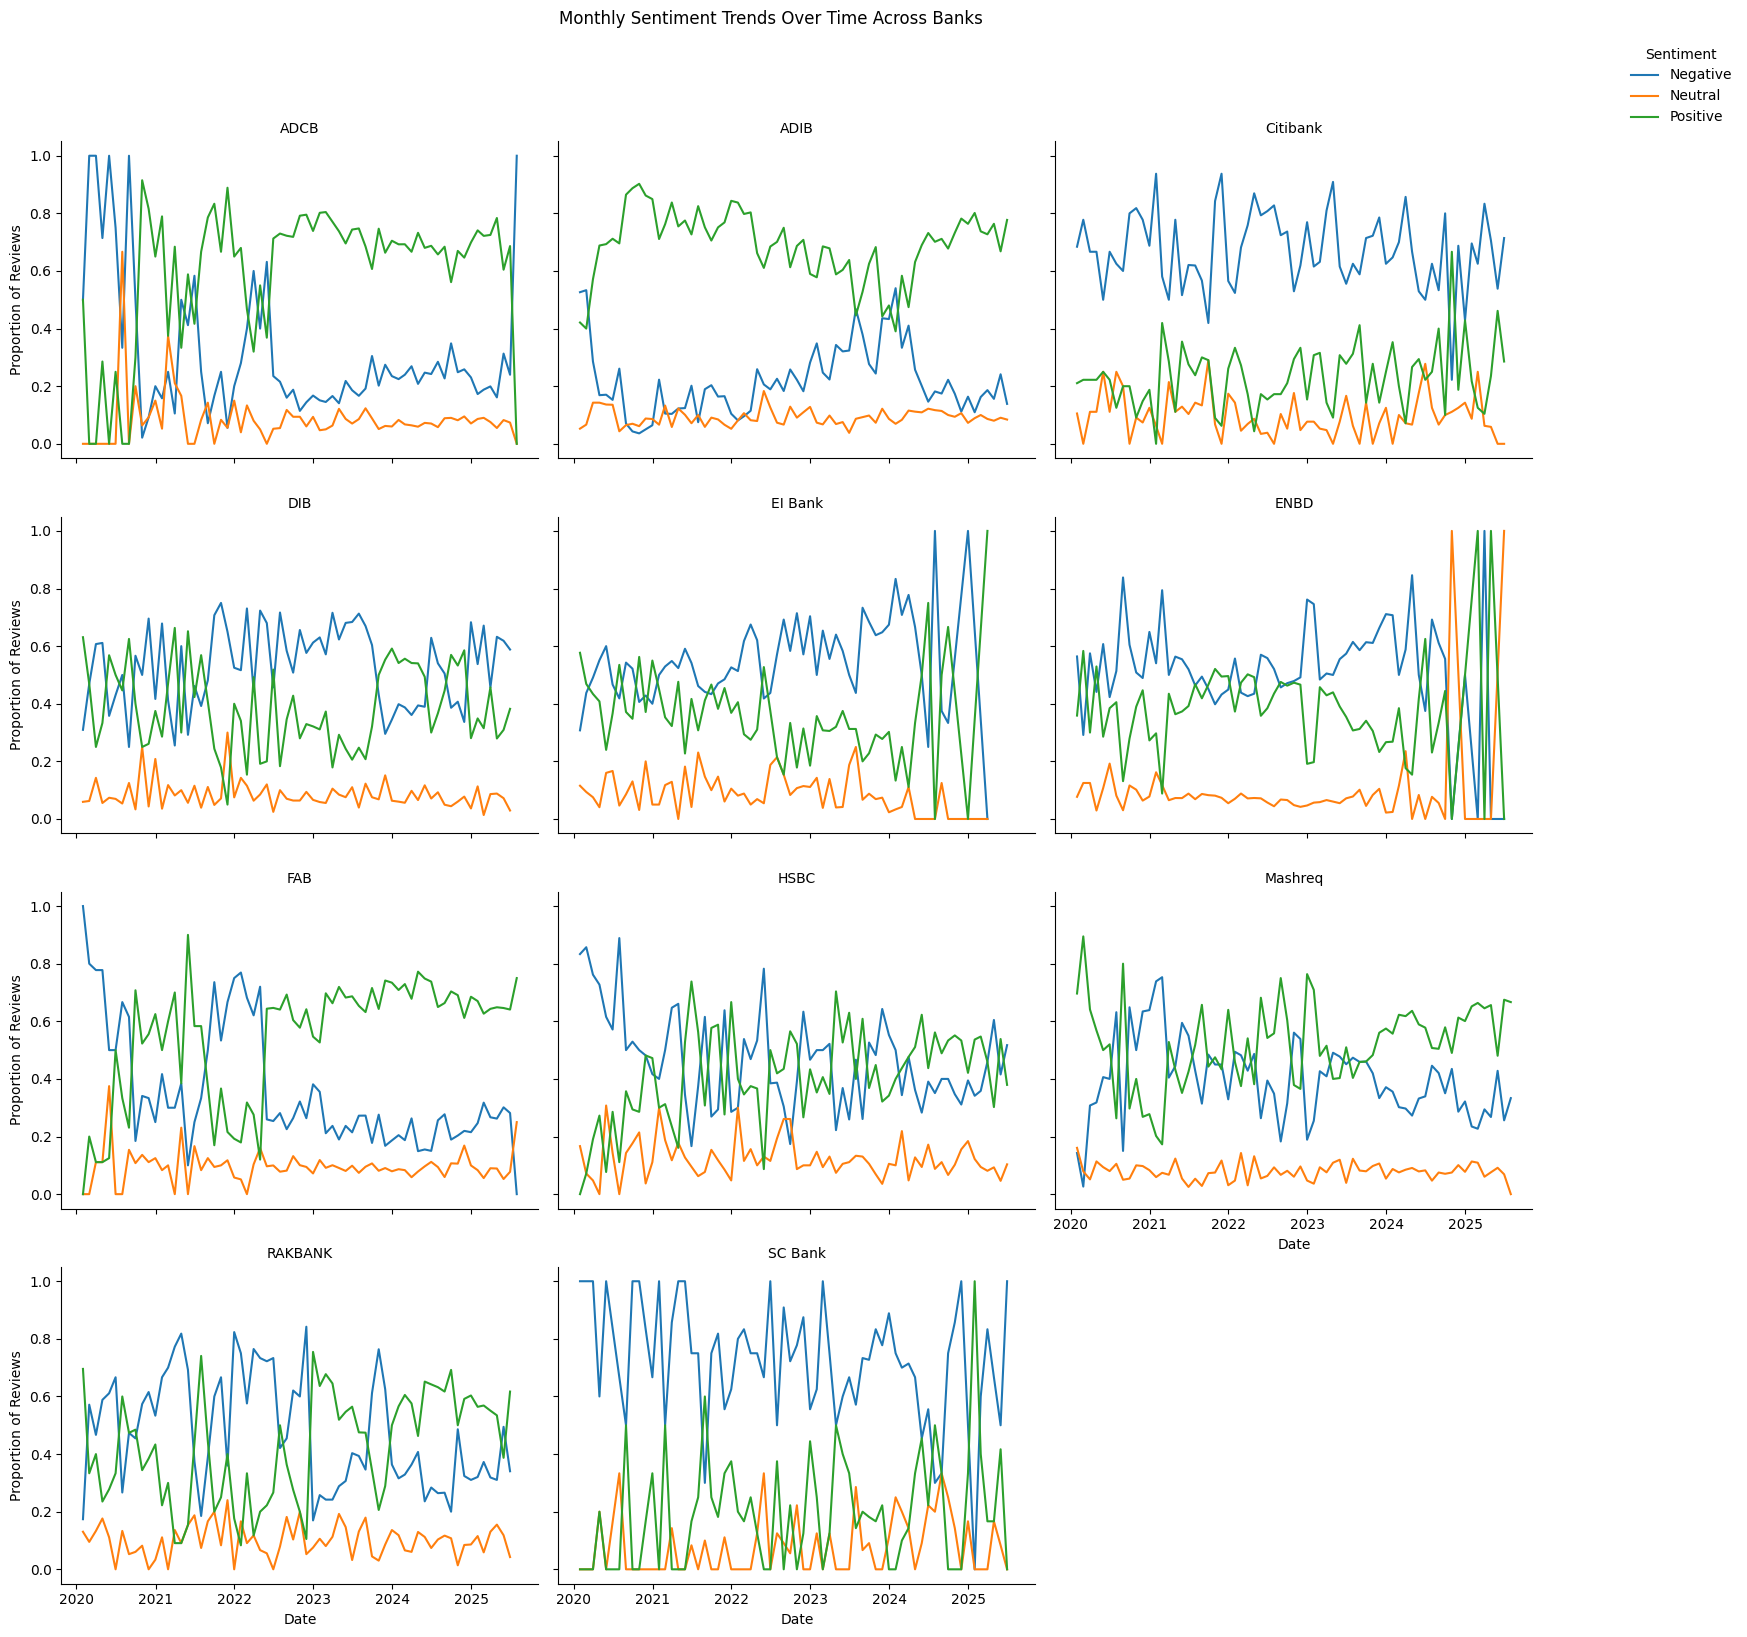

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'reviewedAt' is in datetime format
df_scored_['reviewedAt'] = pd.to_datetime(df_scored_['reviewedAt'])

# Ensure 'reviewedAt' is a column by resetting the index unconditionally
df_scored_ = df_scored_.reset_index(drop=True)

# Group by 'app_name' and 'Sentiment', then resample to monthly frequency and count
monthly_sentiment_by_bank = df_scored_.groupby(['app_name', 'Sentiment']).resample('M', on='reviewedAt').size().unstack(fill_value=0)

# Calculate the proportion of each sentiment per month *within each bank*
# This requires unstacking the sentiment level to divide by the total monthly reviews for each bank
monthly_sentiment_by_bank = monthly_sentiment_by_bank.stack().reset_index(name='count')

# Calculate the total count of reviews per bank per month to get proportions
monthly_total_by_bank = monthly_sentiment_by_bank.groupby(['app_name', 'reviewedAt'])['count'].transform('sum')

# Calculate the proportion
monthly_sentiment_by_bank['proportion'] = monthly_sentiment_by_bank['count'] / monthly_total_by_bank

# Rename columns for clarity
monthly_sentiment_by_bank = monthly_sentiment_by_bank.rename(columns={'level_2': 'Sentiment'})


# Plotting the temporal trends of sentiment across banks using FacetGrid
g = sns.FacetGrid(monthly_sentiment_by_bank, col="app_name", col_wrap=3, height=4, aspect=1.2)
g.map_dataframe(sns.lineplot, x="reviewedAt", y="proportion", hue="Sentiment")
g.add_legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Position the legend outside the plots
g.fig.suptitle('Monthly Sentiment Trends Over Time Across Banks', y=1.02)
g.set_axis_labels("Date", "Proportion of Reviews")
g.set_titles("{col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

### This series of line plots displays the monthly sentiment trends for each bank individually. Each subplot represents a different bank and shows the proportion of Negative, Neutral, and Positive reviews over time for that specific bank. This allows for a detailed comparison of sentiment dynamics across different banks.

## Overall Sentiment Proportion by TAT Group

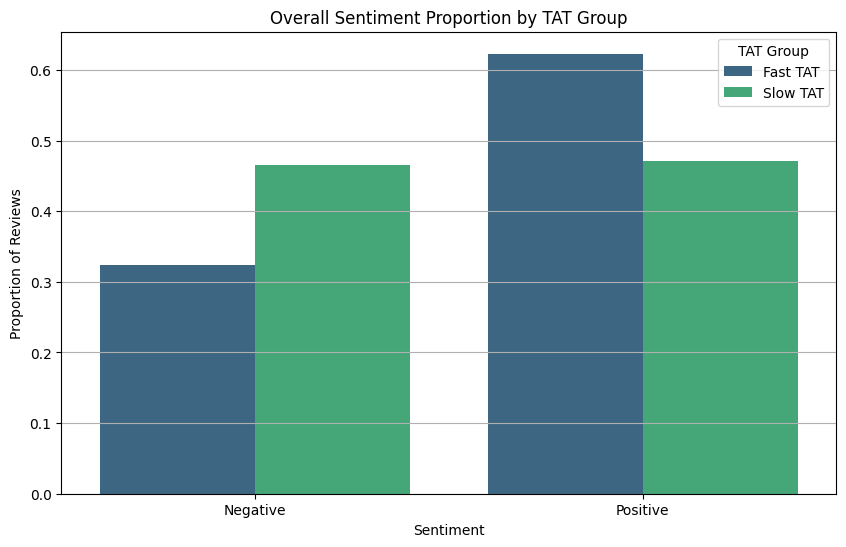

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for replied reviews
replied_df = df_scored_[df_scored_['Response_Status'] == 'Replied'].copy()

# Calculate overall sentiment proportions for Fast and Slow TAT groups
overall_sentiment_proportions = replied_df.groupby(['TAT_Group', 'Prediction']).size().unstack(fill_value=0)
overall_sentiment_proportions = overall_sentiment_proportions.apply(lambda x: x / x.sum(), axis=1).stack().reset_index(name='proportion')

# Filter for Positive and Negative sentiments
overall_sentiment_proportions = overall_sentiment_proportions[
    overall_sentiment_proportions['Prediction'].isin(['Positive', 'Negative'])
]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=overall_sentiment_proportions, x='Prediction', y='proportion', hue='TAT_Group', palette='viridis')

plt.title('Overall Sentiment Proportion by TAT Group')
plt.xlabel('Sentiment')
plt.ylabel('Proportion of Reviews')
plt.legend(title='TAT Group')
plt.grid(axis='y')
plt.show()

### The bar plot compares the overall proportion of Negative and Positive sentiments between reviews with Fast Turnaround Time (TAT) and Slow TAT. It clearly shows that reviews with Fast TAT have a higher proportion of Positive sentiment and a lower proportion of Negative sentiment compared to reviews with Slow TAT.

## Sentiment Proportion by TAT Group and Bank

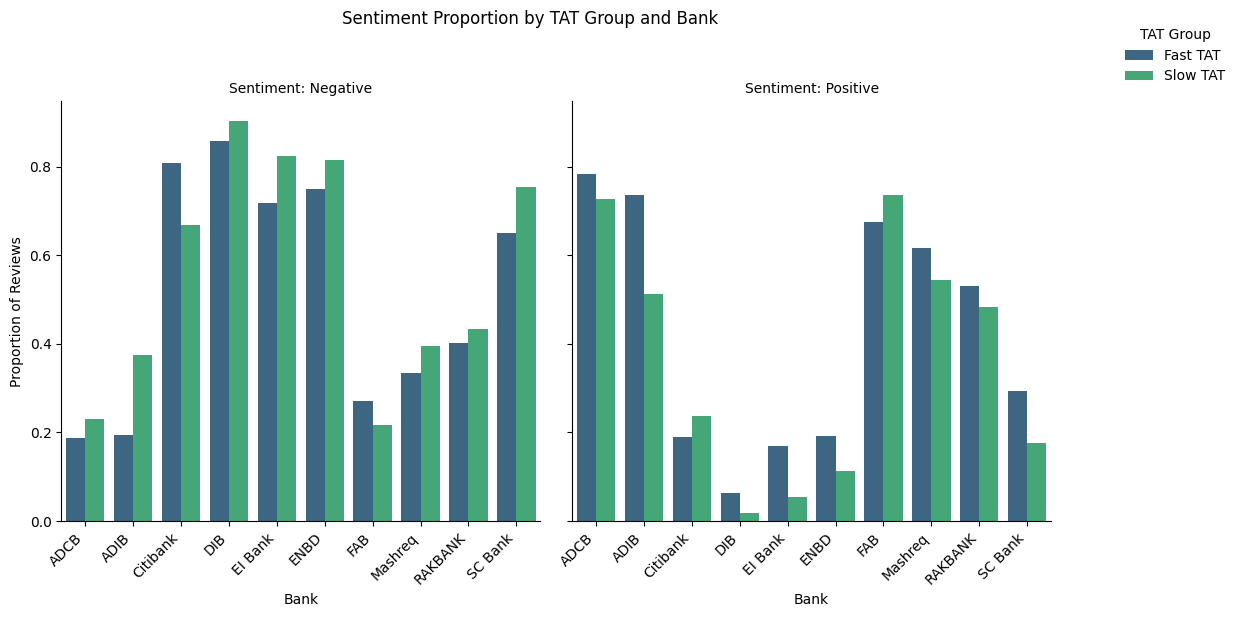

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter for replied reviews
replied_df = df_scored_[df_scored_['Response_Status'] == 'Replied'].copy()

# Calculate sentiment proportions for Fast and Slow TAT groups by bank
sentiment_proportions_by_tat_bank = replied_df.groupby(['app_name', 'TAT_Group', 'Prediction']).size().unstack(fill_value=0)
sentiment_proportions_by_tat_bank = sentiment_proportions_by_tat_bank.apply(lambda x: x / x.sum(), axis=1).stack().reset_index(name='proportion')

# Filter for Positive and Negative sentiments as these were used in z-tests
sentiment_proportions_by_tat_bank = sentiment_proportions_by_tat_bank[
    sentiment_proportions_by_tat_bank['Prediction'].isin(['Positive', 'Negative'])
]

# Plotting
g = sns.FacetGrid(sentiment_proportions_by_tat_bank, col="Prediction", col_wrap=2, height=6, aspect=0.8)
g.map(sns.barplot, 'app_name', 'proportion', 'TAT_Group', palette='viridis', order=sentiment_proportions_by_tat_bank['app_name'].unique(), hue_order=sentiment_proportions_by_tat_bank['TAT_Group'].unique())

g.add_legend(title='TAT Group',bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Position the legend outside the plots
g.fig.suptitle('Sentiment Proportion by TAT Group and Bank', y=1.02)
g.set_axis_labels("Bank", "Proportion of Reviews")
g.set_xticklabels(rotation=45, ha='right')
g.set_titles("Sentiment: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

### This faceted bar plot shows the proportion of Negative and Positive sentiments for each bank, further broken down by Fast and Slow TAT groups. It allows for a bank-by-bank comparison of how TAT relates to sentiment, highlighting which banks have a larger difference in sentiment between fast and slow responses.

## Comparison of Sentiment Derived from Rating vs. Model Prediction

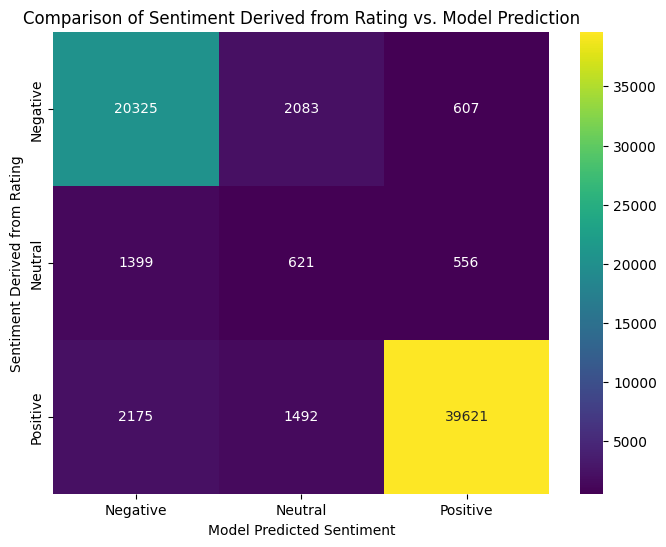

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'Sentiment_from_Rating' is created if it's not already present (assuming 'rating' is available)
if 'Sentiment_from_Rating' not in df_scored_.columns:
    def derive_sentiment_from_rating(rating):
        if rating >= 4:
            return 'Positive'
        elif rating <= 2:
            return 'Negative'
        else:
            return 'Neutral'
    df_scored_['Sentiment_from_Rating'] = df_scored_['rating'].apply(derive_sentiment_from_rating)


# Create a cross-tabulation of the two sentiment columns
sentiment_comparison = pd.crosstab(df_scored_['Sentiment_from_Rating'], df_scored_['Prediction'])

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sentiment_comparison, annot=True, fmt='d', cmap='viridis')
plt.title('Comparison of Sentiment Derived from Rating vs. Model Prediction')
plt.xlabel('Model Predicted Sentiment')
plt.ylabel('Sentiment Derived from Rating')
plt.show()

### The heatmap shows the comparison between sentiment derived directly from the rating (Negative: 1-2, Neutral: 3, Positive: 4-5) and the sentiment predicted by the model. The diagonal cells show the number of reviews where the two methods agree. Significant off-diagonal values indicate discrepancies between rating-based sentiment and model-predicted sentiment. There are significant differences where ratings which seems to be Positive are found to be Negative and few reviews with very less rating (Negative) found to be Neutral

# Distribution of Turnaround Time for Replied Reviews

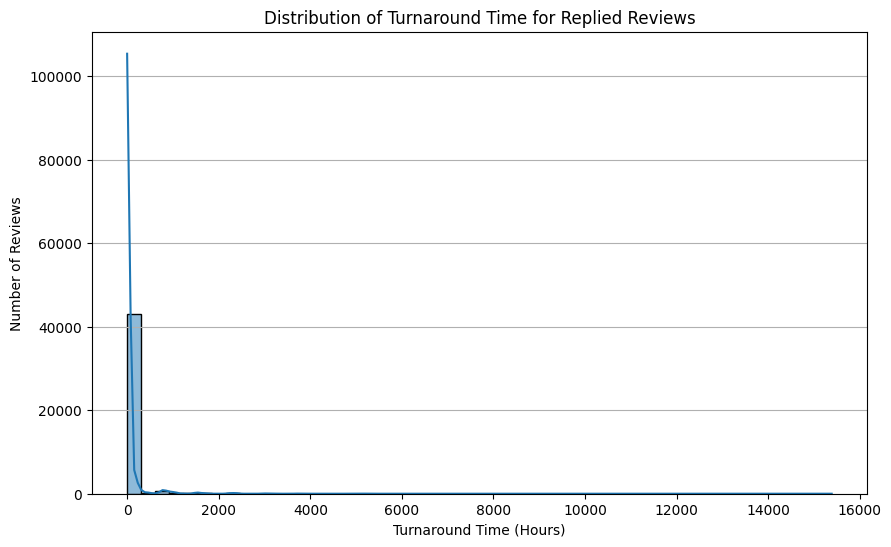

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for replied reviews
replied_df = df_scored_[df_scored_['Response_Status'] == 'Replied'].copy()

# Visualize the distribution of Turnaround Time (reply_in) for replied reviews
plt.figure(figsize=(10, 6))
sns.histplot(data=replied_df, x='reply_in', bins=50, kde=True) # Adjust bin number as needed
plt.title('Distribution of Turnaround Time for Replied Reviews')
plt.xlabel('Turnaround Time (Hours)')
plt.ylabel('Number of Reviews')
plt.grid(axis='y')
plt.show()

### The histogram displays the distribution of turnaround time (in hours) for reviews that received a reply. The distribution is highly skewed to the right, indicating that most reviews are replied to relatively quickly, with a long tail of reviews that take significantly longer to receive a response.

## Kruskal-Wallis H Test for Turnaround Time across Sentiment Groups

In [ ]:
from scipy import stats

# Filter for replied reviews and drop rows with NaN in 'reply_in'
replied_df = df_scored_[df_scored_['Response_Status'] == 'Replied'].dropna(subset=['reply_in']).copy()

# Separate 'reply_in' values for each sentiment group
negative_tat = replied_df[replied_df['Prediction'] == 'Negative']['reply_in']
neutral_tat = replied_df[replied_df['Prediction'] == 'Neutral']['reply_in']
positive_tat = replied_df[replied_df['Prediction'] == 'Positive']['reply_in']

# Perform Kruskal-Wallis H test
# Null Hypothesis (H0): The median TAT is the same across all sentiment groups.
# Alternative Hypothesis (H1): The median TAT is different for at least one sentiment group.
h_statistic, p_value = stats.kruskal(negative_tat, neutral_tat, positive_tat)

print("Kruskal-Wallis H Test for Turnaround Time across Sentiment Groups:")
print(f"  Null Hypothesis (H0): The median TAT is the same across all sentiment groups.")
print(f"  Alternative Hypothesis (H1): The median TAT is different for at least one sentiment group.")
print(f"  H-statistic: {h_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("  Result: Reject null hypothesis - Significant difference in median TAT between sentiment groups.")
else:
    print("  Result: Fail to reject null hypothesis - No significant difference in median TAT between sentiment groups.")

Kruskal-Wallis H Test for Turnaround Time across Sentiment Groups:
  Null Hypothesis (H0): The median TAT is the same across all sentiment groups.
  Alternative Hypothesis (H1): The median TAT is different for at least one sentiment group.
  H-statistic: 963.5729
  P-value: 0.0000
  Result: Reject null hypothesis - Significant difference in median TAT between sentiment groups.


## Turnaround Time Distribution by Overall Sentiment (Outliers Removed)

/tmp/ipython-input-3571173352.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=replied_df, x=sentiment_col, y='reply_in', palette='viridis', order=['Negative', 'Neutral', 'Positive'], showfliers=False)


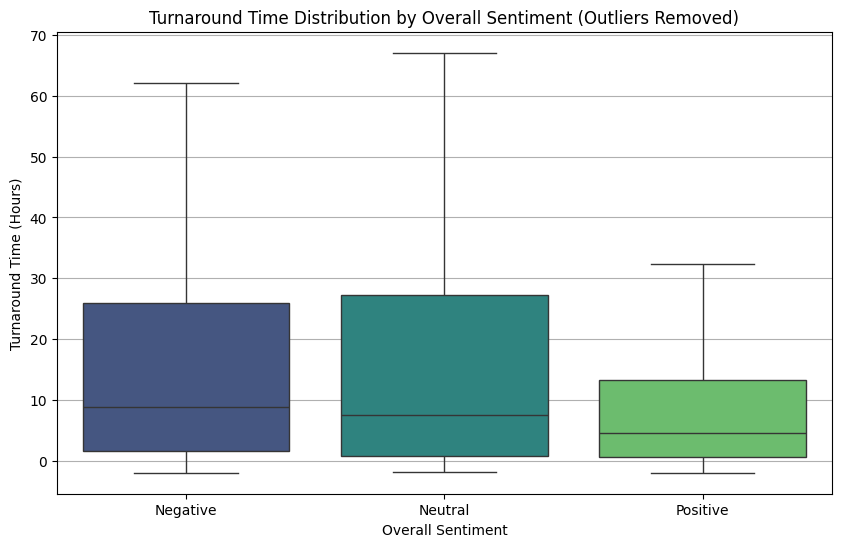

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for replied reviews
replied_df = df_scored_[df_scored_['Response_Status'] == 'Replied'].copy()

# Ensure 'Prediction' is used for sentiment
sentiment_col = 'Prediction'

# Create a box plot of Turnaround Time by Sentiment, hiding outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=replied_df, x=sentiment_col, y='reply_in', palette='viridis', order=['Negative', 'Neutral', 'Positive'], showfliers=False)
plt.title('Turnaround Time Distribution by Overall Sentiment (Outliers Removed)')
plt.xlabel('Overall Sentiment')
plt.ylabel('Turnaround Time (Hours)')
plt.grid(axis='y')
plt.show()

### Reviews with more negative sentiment tend to have longer turnaround times, while reviews with positive sentiment are typically responded to more quickly. This visual evidence supports the hypothesis that there is a correlation between longer TATs and lower sentiment scores, which was also indicated by the statistically significant results of the two-proportion z-tests we performed earlier.